# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу NVBaranov_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (названия колонок + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после завершения Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. **Допускается применение любых моделей машинного обучения из библиотеки sklearn.**
11. Решение не должно полностью повторять этот скрипт

### Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков (лучше выполнять действия сразу для двух датасетов)
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [4]:
def evaluate_preds(train_true_values, train_pred_values, val_true_values, val_pred_values):
    """
    Функция для оценки работы модели
    Parameters:
    train_true_values - целевая переменная из тренировочной части датасета
    train_pred_values - предсказания модели по тренировочной части
    val_true_values - целевая переменная из валидационной части датасета
    val_pred_values - предсказания модели по валидационной части
    Returns:
    R2 на тренировочной и валидационной части, 
    графики зависимости истинных значений от предсказаний
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Valid R2:\t" + str(round(r2(val_true_values, val_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=val_pred_values, y=val_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    plt.show()

**Пути к директориям и файлам**

In [31]:
TRAIN_DATASET_PATH = 'datasets/project_task/train.csv'
TEST_DATASET_PATH = 'datasets/project_task/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [54]:
train_df = pd.read_csv(TRAIN_DATASET_PATH).set_index('Id')
display(train_df.tail())
print(train_df.shape)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
77,32,2.00000,50.40178,30.47620,5.00000,6,5.00000,1968,0.13565,B,B,46,7960,6,350.00000,3,11,B,196684.31604
6159,18,1.00000,41.52155,20.53922,9.00000,13,13.00000,2000,0.00000,B,B,30,5562,0,nan,0,5,A,189050.28957
5123,27,1.00000,47.93901,nan,1.00000,12,16.00000,2015,0.07216,B,B,2,629,1,nan,0,0,A,159143.80537
5400,75,2.00000,43.60256,33.84015,8.00000,1,5.00000,1961,0.30747,B,A,30,5048,9,325.00000,2,5,B,181595.33981
6306,128,1.00000,38.66664,21.15787,8.00000,7,17.00000,1990,0.00000,B,B,27,4798,0,30.00000,2,8,B,218714.07762


(10000, 19)


In [7]:
train_idxs = list(train_df.index)

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH).set_index('Id')
display(test_df.tail())
print(test_df.shape)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
8180,11,3.00000,67.13391,50.80980,6.00000,5,9.00000,1973,0.00017,B,B,36,5992,0,nan,1,1,B
4695,1,1.00000,40.19847,21.80706,10.00000,12,17.00000,2017,0.00712,B,B,1,264,0,nan,0,1,B
5783,12,3.00000,77.84218,48.28263,9.00000,23,22.00000,1989,0.09080,B,B,74,19083,2,nan,5,15,B
4780,62,2.00000,81.30522,nan,0.00000,4,0.00000,1977,0.07216,B,B,2,629,1,nan,0,0,A
12504,30,2.00000,60.55569,nan,1.00000,10,17.00000,1977,0.00008,B,B,22,6398,141,1046.00000,3,23,B


(5000, 18)


In [12]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов

In [13]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [15]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

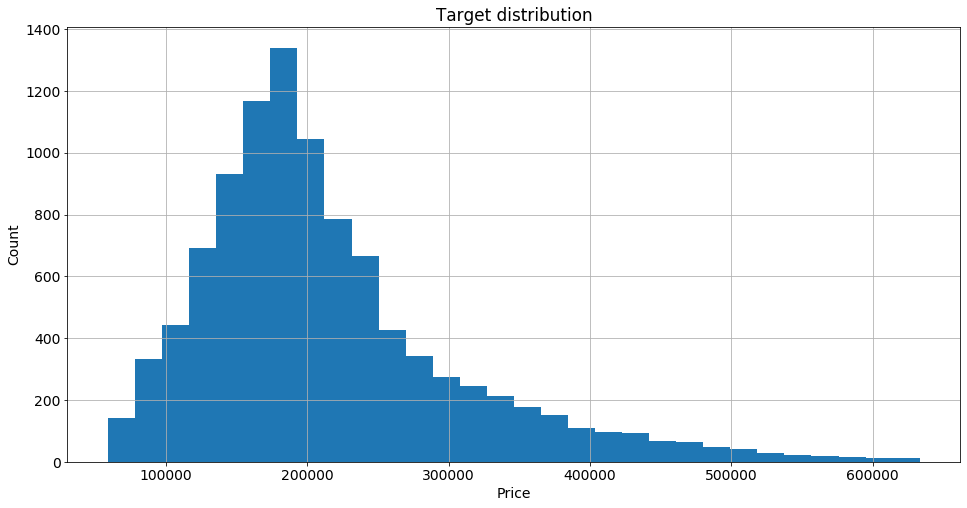

In [16]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [17]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.00000,1.89050,0.83951,0.00000,1.00000,2.00000,2.00000,19.00000
Square,10000.00000,56.31578,21.05873,1.13686,41.77488,52.51331,65.90063,641.06519
LifeSquare,7887.00000,37.19964,86.24121,0.37062,22.76983,32.78126,45.12880,7480.59213
KitchenSquare,10000.00000,6.27330,28.56092,0.00000,1.00000,6.00000,9.00000,2014.00000
Floor,10000.00000,8.52670,5.24115,1.00000,4.00000,7.00000,12.00000,42.00000
HouseFloor,10000.00000,12.60940,6.77597,0.00000,9.00000,13.00000,17.00000,117.00000
HouseYear,10000.00000,3990.16630,200500.26143,1910.00000,1974.00000,1977.00000,2001.00000,20052011.00000
Ecology_1,10000.00000,0.11886,0.11903,0.00000,0.01765,0.07542,0.19578,0.52187
Social_1,10000.00000,24.68700,17.53261,0.00000,6.00000,25.00000,36.00000,74.00000
Social_2,10000.00000,5352.15740,4006.79980,168.00000,1564.00000,5285.00000,7227.00000,19083.00000


In [19]:
train_df.describe(include=['O']).T

,count,unique,top,freq
DistrictId,10000,205,27,851
Ecology_2,10000,2,B,9903
Ecology_3,10000,2,B,9725
Shops_2,10000,2,B,9175


**Категориальные переменные**

In [20]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [21]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Обработка выбросов

**Rooms**

In [23]:
train_df['Rooms'].value_counts()

2.00000     3880
1.00000     3705
3.00000     2235
4.00000      150
5.00000       18
0.00000        8
10.00000       2
19.00000       1
6.00000        1
Name: Rooms, dtype: int64

In [24]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

In [25]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.00000,7887.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,5202.00000,10000.00000,10000.00000,10000.00000
mean,1.88880,56.31578,37.19964,6.27330,8.52670,12.60940,3990.16630,0.11886,24.68700,5352.15740,8.03920,1142.90446,1.31950,4.23130,214138.85740
std,0.81210,21.05873,86.24121,28.56092,5.24115,6.77597,200500.26143,0.11903,17.53261,4006.79980,23.83187,1021.51726,1.49360,4.80634,92872.29387
min,1.00000,1.13686,0.37062,0.00000,1.00000,0.00000,1910.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.77488,22.76983,1.00000,4.00000,9.00000,1974.00000,0.01765,6.00000,1564.00000,0.00000,350.00000,0.00000,1.00000,153872.63394
50%,2.00000,52.51331,32.78126,6.00000,7.00000,13.00000,1977.00000,0.07542,25.00000,5285.00000,2.00000,900.00000,1.00000,3.00000,192269.64488
75%,2.00000,65.90063,45.12880,9.00000,12.00000,17.00000,2001.00000,0.19578,36.00000,7227.00000,5.00000,1548.00000,2.00000,6.00000,249135.46217
max,6.00000,641.06519,7480.59213,2014.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [26]:
steps = []
scores = [] # <- записываем финальный score

In [27]:
steps.append('обработка пропусков, выбросов var1')

train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [ ]:
# steps.append('обработка пропусков, выбросов var2')

"""
...
...
...
"""

In [28]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.00000,8881.00000,7296.00000,8881.00000,8881.00000,8881.00000,8881.00000,8881.00000,8881.00000,8881.00000,8881.00000,4799.00000,8881.00000,8881.00000,8881.00000
mean,1.88459,54.80949,34.83030,6.07533,8.44668,12.82693,4242.53181,0.11962,26.07116,5630.48001,8.40378,1156.07293,1.39264,4.43858,214939.47905
std,0.79700,16.22535,14.28053,3.50361,5.13376,6.36921,212757.07633,0.11965,17.26970,3977.90281,24.29521,1032.81442,1.49209,4.83734,89654.20967
min,1.00000,29.71993,2.94144,1.00000,1.00000,0.00000,1914.00000,0.00000,0.00000,168.00000,0.00000,0.00000,0.00000,0.00000,59174.77803
25%,1.00000,41.63755,22.86380,1.00000,4.00000,9.00000,1972.00000,0.01765,10.00000,2370.00000,0.00000,325.00000,0.00000,1.00000,156934.44009
50%,2.00000,51.65601,32.45993,6.00000,7.00000,14.00000,1977.00000,0.07578,25.00000,5562.00000,2.00000,990.00000,1.00000,3.00000,194240.53450
75%,2.00000,64.72092,44.11977,9.00000,12.00000,17.00000,2000.00000,0.19449,36.00000,7614.00000,5.00000,1548.00000,3.00000,6.00000,250381.58078
max,6.00000,117.85597,88.38136,14.00000,42.00000,117.00000,20052011.00000,0.52187,74.00000,19083.00000,141.00000,4849.00000,6.00000,23.00000,633233.46657


In [29]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [55]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = np.nan
train_df.loc[train_df['KitchenSquare'] > 1000 , 'KitchenSquare'] = np.nan

In [56]:
train_df[['KitchenSquare']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 1 columns):
KitchenSquare    6837 non-null float64
dtypes: float64(1)
memory usage: 156.2 KB


In [8]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [11]:
imputer = IterativeImputer(max_iter=100)

In [57]:
train_df[['KitchenSquare']]

,KitchenSquare
Id,
14038,6.00000
15053,8.00000
4765,nan
5809,9.00000
10783,7.00000
...,...
77,5.00000
6159,9.00000
5123,nan


In [58]:
imp_arr = pd.DataFrame(imputer.fit_transform(train_df.select_dtypes(exclude='object')))

In [59]:
imp_arr.columns = train_df.select_dtypes(exclude='object').columns
imp_arr[['KitchenSquare']]

,KitchenSquare
0,6.00000
1,8.00000
2,7.32900
3,9.00000
4,7.00000
...,...
9995,5.00000
9996,9.00000
9997,10.08926
9998,8.00000


**HouseFloor, Floor**

In [31]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [39]:
# train_df[train_df['HouseFloor']==117][['Floor', 'Price']]

In [32]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42])

In [33]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [41]:
# train_df[train_df['Floor'] > train_df['HouseFloor']]

In [60]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))


ValueError: empty range for randrange() (1,1, 0)

**HouseYear**

In [43]:
train_df['HouseYear'].sort_values().unique()

array([    1914,     1916,     1917,     1918,     1919,     1928,
           1929,     1930,     1931,     1932,     1933,     1934,
           1935,     1936,     1937,     1938,     1939,     1940,
           1941,     1942,     1947,     1948,     1950,     1951,
           1952,     1953,     1954,     1955,     1956,     1957,
           1958,     1959,     1960,     1961,     1962,     1963,
           1964,     1965,     1966,     1967,     1968,     1969,
           1970,     1971,     1972,     1973,     1974,     1975,
           1976,     1977,     1978,     1979,     1980,     1981,
           1982,     1983,     1984,     1985,     1986,     1987,
           1988,     1989,     1990,     1991,     1992,     1993,
           1994,     1995,     1996,     1997,     1998,     1999,
           2000,     2001,     2002,     2003,     2004,     2005,
           2006,     2007,     2008,     2009,     2010,     2011,
           2012,     2013,     2014,     2015,     2016,     2

In [44]:
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011

In [45]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Обработка пропусков

In [46]:
train_df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [47]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
Id,,,
14038,47.98156,29.44275,6.00000
15053,65.68364,40.04954,8.00000
5809,53.35298,52.73151,9.00000
10783,39.64919,23.77617,7.00000
12915,80.38448,46.68372,12.00000
14549,62.25411,37.16038,7.00000
5172,64.51144,nan,3.00000
8649,46.46141,18.91555,8.00000
15370,46.30491,27.92258,6.00000


**LifeSquare**

In [48]:
# медиана до корректировки
train_df['LifeSquare'].median()

32.459930868446605

In [49]:
# медиана расхождения площадей
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare']
                   - train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.490551802890103

In [50]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = (
    train_df.loc[train_df['LifeSquare'].isnull(), 'Square']
    - train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare']
    - square_med_diff
)

In [51]:
train_df['LifeSquare'].median()

33.273699979715275

**Healthcare_1**

In [52]:
train_df['Healthcare_1'].head()

Id
14038          nan
15053    240.00000
5809    1084.00000
10783   2078.00000
12915    990.00000
Name: Healthcare_1, dtype: float64

In [53]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### Построение новых признаков

**Dummies**

In [54]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [59]:
pd.get_dummies(train_df['Ecology_2']).head()

,A,B
Id,,
14038,0,1
15053,0,1
5809,0,1
10783,0,1
12915,0,1


**DistrictSize, IsDistrictLarge**

In [60]:
train_df['DistrictId'].value_counts()

27     628
1      537
23     449
6      396
9      279
30     209
53     166
21     162
62     150
58     146
8      139
11     127
52     118
61     118
46     113
57     104
44     102
47      97
99      95
13      95
45      94
101     90
74      90
94      88
34      86
7       86
41      86
29      85
84      79
48      78
3       77
28      77
22      73
2       73
37      72
85      71
96      69
25      68
90      67
75      65
12      64
128     63
93      62
67      60
66      60
26      60
55      58
39      57
88      56
10      55
59      54
105     53
17      52
18      51
31      51
119     49
111     48
78      44
0       44
91      43
124     43
63      42
42      41
109     41
77      40
129     40
79      40
113     37
15      35
103     33
5       33
32      33
80      31
83      30
56      30
19      30
69      29
64      28
130     28
24      28
123     28
87      27
108     27
138     27
70      27
86      26
100     25
122     25
38      25
54      24
120     24

In [61]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
# train_df['DistrictId_cnt'] = train_df['DistrictId'].map(train_df.groupby('DistrictId').size())
district_size.head()

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279


In [62]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,B,B,33,7976,5,990.00000,0,11,B,184966.93073,1,1,1,20
1,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,B,B,46,10309,1,240.00000,1,16,B,300009.45006,1,1,1,86
2,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,B,B,23,5735,3,1084.00000,0,5,B,175616.22722,1,1,1,146
3,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,B,B,35,5776,1,2078.00000,2,4,B,150226.53164,1,1,1,95
4,59,3.00000,80.38448,46.68372,12.00000,5,17.00000,2011,0.30948,B,B,35,7715,4,990.00000,0,6,B,215898.44774,1,1,1,54


In [63]:
(train_df['DistrictSize'] > 100).value_counts()

False    4938
True     3943
Name: DistrictSize, dtype: int64

In [64]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

### Mean encoding

**MedPriceByDistrict**

In [66]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.00000,147258.73662
1,0,2.00000,176210.81233
2,0,3.00000,300610.35942
3,1,1.00000,146154.35225
4,1,2.00000,202944.33150


In [67]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,35,2.00000,47.98156,29.44275,6.00000,7,9.00000,1969,0.08904,B,B,33,7976,5,990.00000,0,11,B,184966.93073,1,1,1,20,0,203384.32803
1,41,3.00000,65.68364,40.04954,8.00000,7,9.00000,1978,0.00007,B,B,46,10309,1,240.00000,1,16,B,300009.45006,1,1,1,86,0,300009.45006
2,58,2.00000,53.35298,52.73151,9.00000,8,17.00000,1977,0.43789,B,B,23,5735,3,1084.00000,0,5,B,175616.22722,1,1,1,146,1,169246.11594
3,99,1.00000,39.64919,23.77617,7.00000,11,12.00000,1976,0.01234,B,B,35,5776,1,2078.00000,2,4,B,150226.53164,1,1,1,95,0,158791.01795
4,59,3.00000,80.38448,46.68372,12.00000,5,17.00000,2011,0.30948,B,B,35,7715,4,990.00000,0,6,B,215898.44774,1,1,1,54,0,384517.54005


In [68]:
train_df['MedPriceByDistrict'].isnull().sum()

0

*Пример переноса признака на test*

In [69]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [70]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 19 columns):
DistrictId            5000 non-null object
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            3959 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null int64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null int64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null object
Ecology_3             5000 non-null object
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Healthcare_1          2623 non-null float64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2               5000 non-null object
MedPriceByDistrict    4919 non-null float64
dtypes: float64(8), int64(7), object(4)
memory usage: 781.2+ KB


### Отбор признаков

In [71]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [88]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'DistrictSize', 'MedPriceByDistrict']

target_name = 'Price'

### Разбиение на train и val

In [92]:
# train_df.drop(columns=['Ecology_2', 'Ecology_3', 'Shops_2', 'DistrictId'], inplace=True)

X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [93]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [94]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin,IsDistrictLarge,DistrictSize,MedPriceByDistrict
6210,2.00000,59.96090,29.02669,9.00000,10,16.00000,2002,0.23862,1,1,26,3889,6,705.00000,3,6,1,0,42,291422.85973
3200,1.00000,48.80470,34.31415,3.00000,15,25.00000,1977,0.24320,1,1,5,1564,0,540.00000,0,0,1,1,396,131271.92442
2376,1.00000,38.19438,22.67531,8.00000,14,14.00000,1996,0.00100,1,1,42,7651,1,990.00000,1,5,1,0,49,156930.56330
8745,3.00000,64.54056,44.77124,6.00000,12,12.00000,1976,0.00772,1,1,38,4788,2,990.00000,0,4,1,0,31,260139.67650
172,3.00000,92.26619,54.76769,12.00000,4,17.00000,2005,0.21844,1,1,21,4472,6,1450.00000,4,7,0,0,13,337095.59807


In [100]:
X_train.shape

(6216, 20)

### Построение модели

**Обучение и оценка модели**

In [95]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=21, verbose=0,
                      warm_start=False)

**Отложенная выборка**

Train R2:	0.953
Valid R2:	0.691


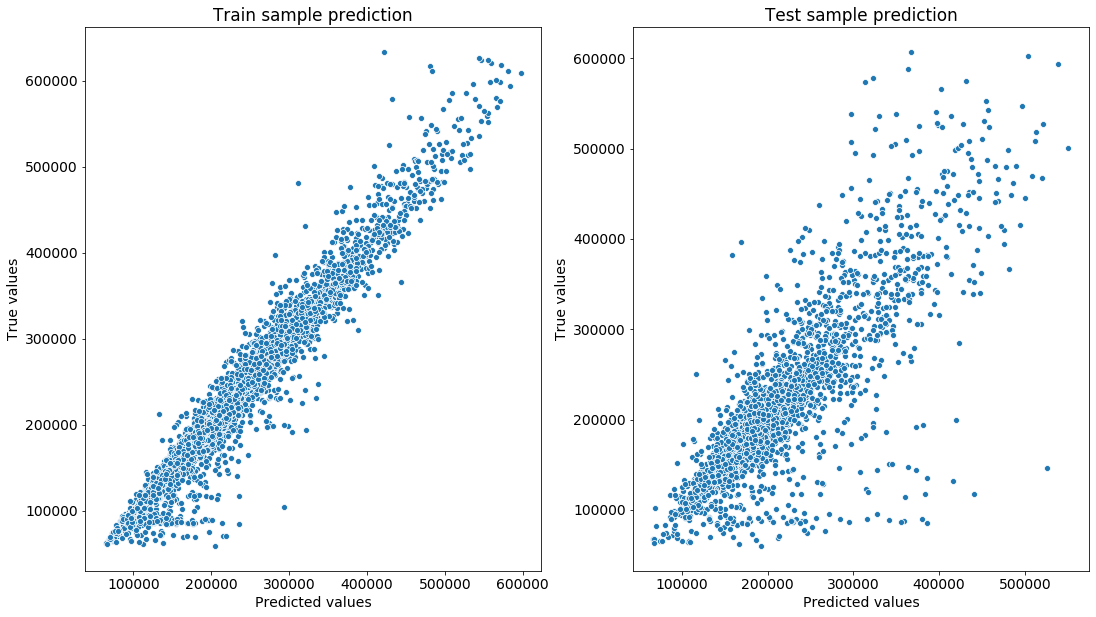

In [96]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_val)

evaluate_preds(y_train, y_train_preds, y_val, y_test_preds)

**Перекрёстная проверка**

In [97]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.68502714, 0.66998002, 0.73132697, 0.74291798, 0.74663518])

In [98]:
cv_score.mean()

0.7151774611804738

**Важность признаков**

In [99]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
19,MedPriceByDistrict,0.62326
1,Square,0.11980
2,LifeSquare,0.03437
6,HouseYear,0.03118
3,KitchenSquare,0.02538
18,DistrictSize,0.02214
12,Social_3,0.02203
5,HouseFloor,0.02019
4,Floor,0.01867
7,Ecology_1,0.01743
